In [16]:
#import the required modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import time

from deepface import DeepFace

file_path = "C:/Users/erdem/Downloads/UTKFace/"

<a href="https://www.kaggle.com/datasets/jangedoo/utkface-new">Dataset</a>

In [26]:
def visualize(images):
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
    samples = images[:8]
    
    
    for i in range(8):
        img = plt.imread(f"{file_path}{samples[i]}")
        gender = samples[i].split("_")[1]
        
        ax[i//4,i%4].set_title(f"{'Male' if gender == '0' else 'Female'}")
        ax[i//4,i%4].imshow(img)
        
        
    plt.tight_layout()
    

def read_data():
    
    return [f for f in listdir(file_path) if isfile(join(file_path, f))]
    

def analyze_deepface(images, detector, short=False, cut=1000):
    
    n_img = len(images)
    results = []

    for idx, image in enumerate(images):
        img = plt.imread(f"{file_path}{image}")

        # storing the result
        result = DeepFace.analyze(img, actions = ['gender'], detector_backend=detector,
                                  enforce_detection=False, silent=True)
        
        results.append(result[0]["dominant_gender"])
        
        if idx%100 == 0:
            if short:
                print(f"progress: {idx}/{cut}")
            else:
                print(f"progress: {idx}/{n_img}")
            
        if short and idx == (cut-1):
            break

    return results


def accuracy(labels, preds):
    
    n = len(preds)
    correct = 0
    
    for idx, p in enumerate(preds):
        true_gender = labels[idx]
        
        if true_gender == p:
            correct += 1
            
    return correct / n

def report(labels, preds):

    cm = confusion_matrix(labels,preds)
 
    # Plot the confusion matrix.
    plt.figure(figsize=(6,5), dpi=120)
    sns.heatmap(cm, annot=True,
                xticklabels=["Man","Woman"],
                yticklabels=["Man","Woman"], fmt="g", cmap="Blues", annot_kws={"size":25})

    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

    print(classification_report(labels, preds))
    plt.show()

## Samples from the dataset

In [18]:
images = read_data()

male = 0
female = 0
total = 0

for img in images:
    gender = img.split("_")[1]
    
    if gender == '0':
        male += 1 
    else:
        female += 1 
        
    total += 1
    
print(f"Male: {male}")
print(f"Female: {female}")
print(f"Male Ratio: {male/total:.3f}")

Male: 12391
Female: 11317
Male Ratio: 0.523


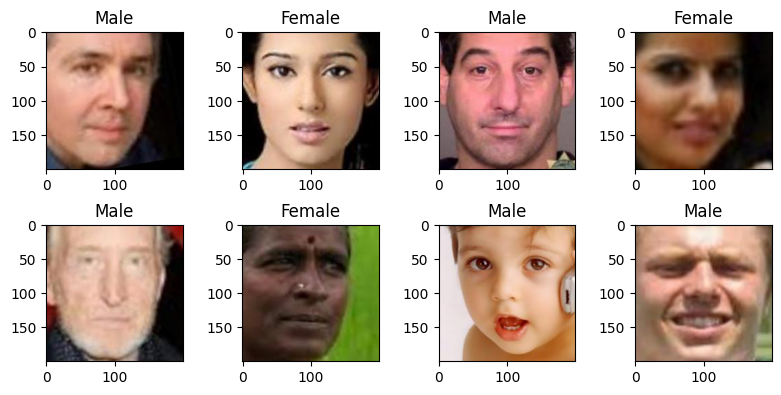

In [19]:
images = read_data()
np.random.shuffle(images)

visualize(images)

## Testing with three different face detectors

In [20]:
detectors = ["opencv", "mtcnn", "mediapipe"]
cut = 500

images = read_data()
np.random.shuffle(images)
labels = ["Man" if i.split("_")[1] == "0" else "Woman" for i in images[:cut]]


deepface_preds = {}
deepface_scores = {}
detector_times = {}

for detector in detectors:
    print(f"\n{detector} started!\n".upper())
    
    start = time.time()
    preds = analyze_deepface(images, detector, short=True, cut=cut)
    
    detector_times[detector] = time.time() - start
    deepface_preds[detector] = preds
    deepface_scores[detector] = accuracy(labels, preds)


OPENCV STARTED!

progress: 0/500
progress: 100/500
progress: 200/500
progress: 300/500
progress: 400/500

MTCNN STARTED!

1/1 [==============================] - 0s 31ms/step
progress: 0/500
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
progress: 100/500
1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step
progress: 200/500
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 35ms/step
progress: 300/500
1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step
progress: 400/500
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 15ms/step

MEDIAPIPE STARTED!

progress: 0/500
progress: 100/500
progress: 200/500
progress: 300/500
progress: 400/500


### results of opencv and mediapipe with 2500 images 

In [21]:
deepface_scores

{'opencv': 0.756, 'mtcnn': 0.784, 'mediapipe': 0.78}

In [22]:
detector_times

{'opencv': 224.05429887771606,
 'mtcnn': 609.2330877780914,
 'mediapipe': 524.6334991455078}

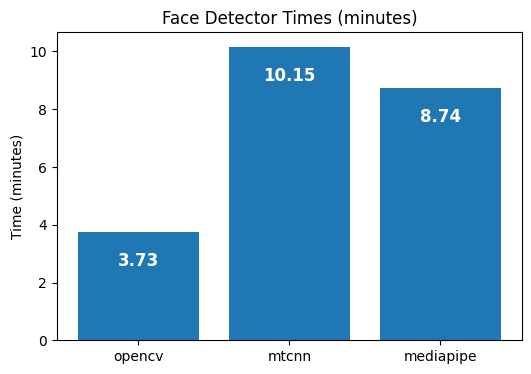

In [23]:
plt.figure(figsize=(6,4))

minutes = [s/60 for s in detector_times.values()]

plt.bar(detector_times.keys(), minutes)

plt.title("Face Detector Times (minutes)")
plt.ylabel("Time (minutes)")
for idx, value in enumerate(minutes):
    plt.text(idx, value-1, f"{value:.2f}", ha="center", va="center", fontsize="large", weight="bold", color="white")

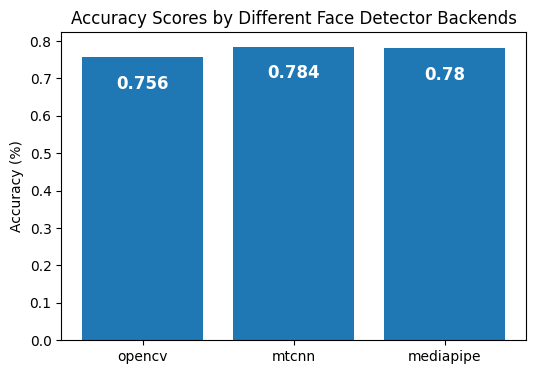

In [24]:
plt.figure(figsize=(6,4))

plt.bar(deepface_scores.keys(), deepface_scores.values())

plt.title("Accuracy Scores by Different Face Detector Backends")
plt.ylabel("Accuracy (%)")

for idx, value in enumerate(deepface_scores.values()):
    plt.text(idx, value-0.07, f"{value}", ha="center", va="center", fontsize="large",weight="bold", color="white")

              precision    recall  f1-score   support

         Man       0.70      0.97      0.82       279
       Woman       0.94      0.48      0.63       221

    accuracy                           0.76       500
   macro avg       0.82      0.73      0.73       500
weighted avg       0.81      0.76      0.74       500



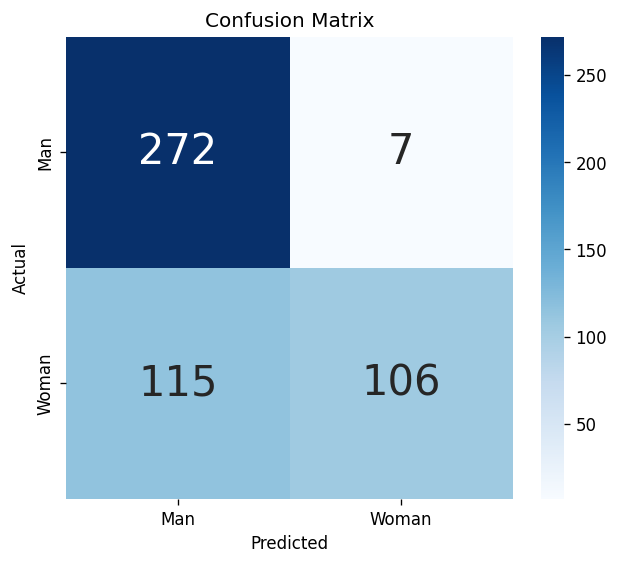

In [27]:
report(labels, deepface_preds["opencv"])

              precision    recall  f1-score   support

         Man       0.73      0.97      0.83       279
       Woman       0.93      0.55      0.69       221

    accuracy                           0.78       500
   macro avg       0.83      0.76      0.76       500
weighted avg       0.82      0.78      0.77       500



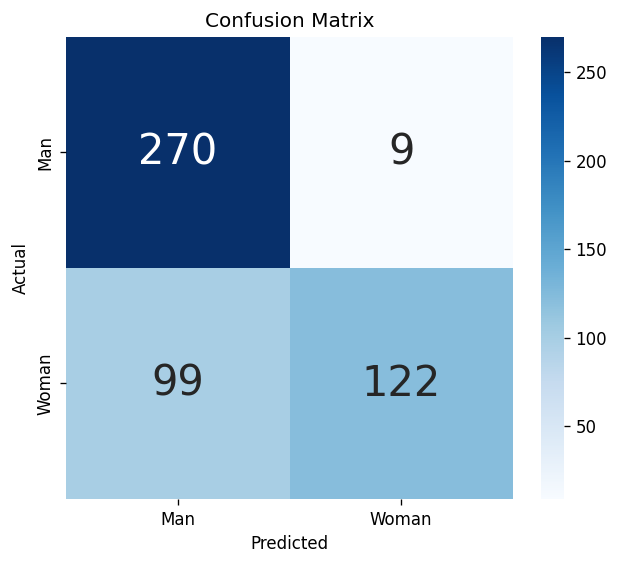

In [28]:
report(labels, deepface_preds["mtcnn"])

              precision    recall  f1-score   support

         Man       0.73      0.96      0.83       279
       Woman       0.92      0.55      0.69       221

    accuracy                           0.78       500
   macro avg       0.83      0.76      0.76       500
weighted avg       0.82      0.78      0.77       500



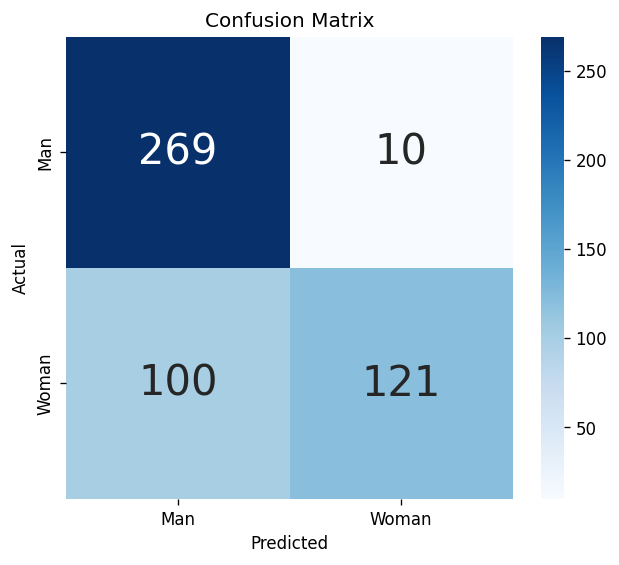

In [29]:
report(labels, deepface_preds["mediapipe"])